# Importando os dados

In [ ]:
# source "C:/Users/leand/venvs/pns/Scripts/activate"
# python -m ipykernel install --user --name=pns --display-name "pns"

import os
import pandas as pd
import seaborn as sns

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os
from tqdm import tqdm

from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [90]:
df_criancas = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/Notebook_PNS/refs/heads/ampliado/data/df_criancas_v2.csv")
df_maes = pd.read_csv("https://raw.githubusercontent.com/LeandroCoelhos/Notebook_PNS/refs/heads/ampliado/data/df_maes_v2.csv")

df_aux = pd.merge(df_criancas, df_maes, on="chave_domicio", how="inner")

df_criancas.shape, df_maes.shape, df_aux.shape

((25353, 221), (9794, 218), (9986, 438))

## Fazer o cruzamento dos Datasets para criar os Clusters de interesse

In [96]:
df_aux = df_aux[['chave_domicio']].drop_duplicates().reset_index(drop=True)
df_grupo_maes = pd.merge(df_maes, df_aux, on="chave_domicio", how="inner" )
df_aux.shape

(7843, 1)

In [97]:
# Remove as crianças mais velhas, no questionáio diz respeito a mais nova
df_criancas = df_criancas.sort_values(by='idade').drop_duplicates(subset=['chave_domicio'], keep='first').reset_index(drop=True)
# Criar um grupo de filhos com maes em idade avançada
df_grupo_criancas = pd.merge(df_criancas, df_grupo_maes[['chave_domicio', 'idade_ultimo_parto', 'parto_idade_avançada']], on="chave_domicio", how="inner" )

In [98]:
df_grupo_maes.parto_idade_avançada.value_counts()

parto_idade_avançada
0    6311
1    1532
Name: count, dtype: int64

# DataPrep

## Renomear algumas colunas do para facilitar o entendimento

In [99]:
cols = ['Q00201',
        'Q03001',
        'Q11604',
        'Q11006',
        'Q092',
        'Q120',
        'T004',
        'Q055012',
        'Q06306',
          'Q060',
          'Q124',
          'Q128',
          'fumante_atual']

cols_rename = ['pressão alta',
        'diabetes',
        'Doença Pulmonar Obstrutiva Crônica',
        'ansiedade, esquizofrenia, bipolar, psicose, TOC',
        'depressão',
        'câncer',
        'doença/infecção sexualmente transmissível',
        'Infarto ou AVC ',
        'doença do coração, infarto, angina, insuficiência cardíaca',
        'colesterol alto',
        'insuficiência renal crônica',
        'doença crônica (física ou mental)',
        'fumante_atual']

df_grupo_maes[cols_rename] = df_grupo_maes[cols]
for col in cols_rename:
    df_grupo_maes[col] = np.where(df_grupo_maes[col]==1, 1, 0)

## Mapear todas as colunas usadas em cada dataframe

In [108]:
# Variaveis explicativas e variaveis resposta
# Variaveis selecionadas das Mães
colunas_maes = [    
'chave_pessoa',
'chave_domicio',
'idade',
'idade_ultimo_parto',
'regiao_brasileira',
'imc_classificacao',
'escolaridade',
'peso_ao_nascer',
'Classificação Idade Gestacional',
'Risco de Insulto Perinatal',
'Complicações Perinatais',
'comorbidade',
'comorbidade_score',
'raca',
'faixa_renda',
'parto_idade_avançada',
'peso_morador_selec',
# Módulo S - Atendimento pré-natal e parto - 15 anos ou mais
"S115",  # Qual foi o tipo de parto?
"S125",  # Teve alguma complicação durante o parto?
"S070", # Quantas consultas de pré-natal fez durante esta gravidez?
 ]

cols_maes = list(set(colunas_maes + cols_rename)) 

colunas_criancas_menores = [
'chave_pessoa',
"regiao_brasileira",
'idade',
'raca',
'sexo',
"L019", #Suplemento de ferroso 1 sim 2 nao
"L033",  # O teste do coraçãozinho realizado deu resultado alterado?
"estado_vacinal",
'J00402', # Algum motivo de saude impediu de realizar atividades habituais?
'J001', # estadod e saude
'J007', # doença cronica
'J012', # Quantidad ed eonsultas medicas nos ultimos 12 meses
]

colunas_criancas_maiores = [
'chave_pessoa',
'chave_domicio',
"regiao_brasileira",
'idade',
'raca',
'sexo',
'J00402', # Algum motivo de saude impediu de realizar atividades habituais?
'J001', # estadod e saude
'J007', # doença cronica
'J012', # Quantidad ed eonsultas medicas nos ultimos 12 meses
'deficiencia',
]

cols_criancas = list(set(colunas_criancas_menores + colunas_criancas_maiores))

df_int_criancas = df_grupo_criancas[cols_criancas].copy()
df_int_maes = df_grupo_maes[cols_maes].copy()

In [109]:
df_int_maes.rename(columns={'S115': 'Qual foi o tipo de parto?', 'S125':'Teve alguma complicação durante o parto?', 'S070':'Quantas consultas de pré-natal fez durante esta gravidez?'}, inplace=True)
df_int_criancas.rename(columns={'J00402': 'Algum motivo de saude impediu de realizar atividades habituais?', 'J001':'estado de saude', 'J007':'doença cronica', 'J012':'Quantidad de consultas medicas nos ultimos 12 meses',
                                'L033':'O teste do coraçãozinho realizado deu resultado alterado?', 'L019':'Suplemento de ferroso' }, inplace=True)
                                

In [110]:
def adiciona_sufix(df, sufix):
    df = df.copy()
    cols = df.columns
    for col in cols:
        if col not in ['chave_domicio']:
            df.rename(columns={col: f"{col}_{sufix}"}, inplace=True)
    return df

df_int_criancas = adiciona_sufix(df_int_criancas, 'filho')
df_int_maes = adiciona_sufix(df_int_maes, 'mae')

## Juntar em um único Dataframe

Juntar variaveis explicativas e variaveis respostas

In [111]:
df_interesse = pd.merge(df_int_maes, df_int_criancas, on="chave_domicio", how="inner", suffixes=('_mae', '_filho'))

In [112]:
# Marcar crianças menores e maiores
df_interesse['idade_filho'] = df_interesse['idade_filho'].astype(int)
df_interesse['filho_menor_2_anos'] = np.where(df_interesse['idade_filho'] < 2, 1, 0)

In [113]:
df_interesse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7843 entries, 0 to 7842
Data columns (total 47 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Doença Pulmonar Obstrutiva Crônica_mae                                 7843 non-null   int64  
 1   fumante_atual_mae                                                      7843 non-null   int64  
 2   doença/infecção sexualmente transmissível_mae                          7843 non-null   int64  
 3   faixa_renda_mae                                                        4087 non-null   object 
 4   Teve alguma complicação durante o parto?_mae                           2650 non-null   float64
 5   peso_ao_nascer_mae                                                     2450 non-null   object 
 6   diabetes_mae                                                           7843 non-null   i

In [114]:
cols = df_interesse.columns
for col in cols:
    print('-'*50)
    display(df_interesse[col].value_counts(dropna=False))
    print('\n\n')

--------------------------------------------------


Doença Pulmonar Obstrutiva Crônica_mae
0    7783
1      60
Name: count, dtype: int64




--------------------------------------------------


fumante_atual_mae
0    7261
1     582
Name: count, dtype: int64




--------------------------------------------------


doença/infecção sexualmente transmissível_mae
0    7766
1      77
Name: count, dtype: int64




--------------------------------------------------


faixa_renda_mae
NaN          3756
1 a <2 SM    1747
<1 SM        1330
2 a <3 SM     414
3 a <5 SM     305
≥5 SM         291
Name: count, dtype: int64




--------------------------------------------------


Teve alguma complicação durante o parto?_mae
NaN    5193
2.0    2311
1.0     339
Name: count, dtype: int64




--------------------------------------------------


peso_ao_nascer_mae
NaN                   5393
Adequado              2047
Baixo peso             202
Macrossomia            176
Baixo peso extremo      25
Name: count, dtype: int64




--------------------------------------------------


diabetes_mae
0    7602
1     241
Name: count, dtype: int64




--------------------------------------------------


Classificação Idade Gestacional_mae
NaN                           5450
A termo                       1847
Prematuro tardio               349
Pós-termo                      144
Prematuro moderado a grave      30
Prematuro extremo               23
Name: count, dtype: int64




--------------------------------------------------


comorbidade_mae
Não    4889
Sim    2954
Name: count, dtype: int64




--------------------------------------------------


ansiedade, esquizofrenia, bipolar, psicose, TOC_mae
0    7352
1     491
Name: count, dtype: int64




--------------------------------------------------


raca_mae
Parda       4612
Branca      2213
Preta        890
Indígena      73
Amarela       55
Name: count, dtype: int64




--------------------------------------------------


Complicações Perinatais_mae
Não    6906
Sim     937
Name: count, dtype: int64




--------------------------------------------------


doença do coração, infarto, angina, insuficiência cardíaca_mae
0    7703
1     140
Name: count, dtype: int64




--------------------------------------------------


regiao_brasileira_mae
Nordeste        2840
Norte           1870
Sudeste         1396
Centro-Oeste     917
Sul              820
Name: count, dtype: int64




--------------------------------------------------


Infarto ou AVC _mae
0    7840
1       3
Name: count, dtype: int64




--------------------------------------------------


colesterol alto_mae
0    7362
1     481
Name: count, dtype: int64




--------------------------------------------------


imc_classificacao_mae
Normal             3269
Sobrepeso          2471
Obesidade          1438
NaN                 349
Magreza             207
Obesidade Grave     109
Name: count, dtype: int64




--------------------------------------------------


comorbidade_score_mae
0    4889
1    1965
2     689
3     207
4      69
5      14
6       8
7       2
Name: count, dtype: int64




--------------------------------------------------


idade_ultimo_parto_mae
30.0    427
28.0    405
27.0    404
29.0    392
24.0    389
31.0    386
25.0    386
32.0    379
26.0    379
23.0    358
21.0    354
22.0    352
33.0    319
35.0    317
34.0    314
20.0    303
36.0    263
19.0    254
37.0    247
18.0    222
38.0    170
17.0    167
39.0    151
40.0    129
41.0     83
16.0     76
42.0     63
15.0     45
43.0     35
44.0     25
45.0     21
46.0     12
47.0      8
49.0      4
50.0      3
52.0      1
Name: count, dtype: int64




--------------------------------------------------


doença crônica (física ou mental)_mae
0    7341
1     502
Name: count, dtype: int64




--------------------------------------------------


Risco de Insulto Perinatal_mae
Não    7562
Sim     281
Name: count, dtype: int64




--------------------------------------------------


idade_mae
30.0    425
31.0    413
32.0    386
29.0    384
34.0    378
27.0    377
35.0    375
33.0    348
26.0    347
37.0    345
24.0    344
28.0    342
25.0    338
36.0    329
23.0    318
38.0    276
22.0    238
39.0    235
21.0    226
40.0    194
41.0    179
20.0    176
42.0    166
19.0    126
43.0    118
18.0     84
44.0     78
45.0     69
17.0     53
46.0     47
47.0     40
16.0     24
48.0     24
49.0     11
15.0      8
50.0      8
51.0      4
52.0      3
55.0      3
53.0      2
56.0      1
54.0      1
Name: count, dtype: int64




--------------------------------------------------


pressão alta_mae
0    6893
1     950
Name: count, dtype: int64




--------------------------------------------------


Quantas consultas de pré-natal fez durante esta gravidez?_mae
NaN    5259
7.0    1856
6.0     308
5.0     183
4.0      97
8.0      61
3.0      44
2.0      24
1.0      11
Name: count, dtype: int64




--------------------------------------------------


peso_morador_selec_mae
0.069757    6
1.035833    6
0.234924    5
0.100584    4
0.320003    4
           ..
0.814680    1
0.271560    1
0.543120    1
0.496386    1
0.062574    1
Name: count, Length: 6884, dtype: int64




--------------------------------------------------


Qual foi o tipo de parto?_mae
NaN    5193
2.0    1387
1.0    1263
Name: count, dtype: int64




--------------------------------------------------


depressão_mae
0    7108
1     735
Name: count, dtype: int64




--------------------------------------------------


insuficiência renal crônica_mae
0    7784
1      59
Name: count, dtype: int64




--------------------------------------------------


chave_domicio
53_5310220_530044434_11    1
11_1110011_110000016_5     1
11_1110011_110000034_10    1
53_5310213_530031134_1     1
53_5310213_530016054_11    1
                          ..
11_1110011_110005390_11    1
11_1110011_110003808_14    1
11_1110011_110003808_13    1
11_1110011_110002149_14    1
11_1110011_110002149_2     1
Name: count, Length: 7843, dtype: int64




--------------------------------------------------


câncer_mae
0    7792
1      51
Name: count, dtype: int64




--------------------------------------------------


escolaridade_mae
Médio            3560
Fundamental      2103
Superior         1019
NaN               760
Pós-graduação     401
Name: count, dtype: int64




--------------------------------------------------


parto_idade_avançada_mae
0    6311
1    1532
Name: count, dtype: int64




--------------------------------------------------


chave_pessoa_mae
53_5310220_530044434_11_1.0    1
11_1110011_110000016_5_1.0     1
11_1110011_110000034_10_1.0    1
53_5310213_530031134_1_2.0     1
53_5310213_530016054_11_1.0    1
                              ..
11_1110011_110005390_11_1.0    1
11_1110011_110003808_14_2.0    1
11_1110011_110003808_13_1.0    1
11_1110011_110002149_14_1.0    1
11_1110011_110002149_2_1.0     1
Name: count, Length: 7843, dtype: int64




--------------------------------------------------


raca_filho
Parda       4279
Branca      2948
Preta        525
Indígena      56
Amarela       35
Name: count, dtype: int64




--------------------------------------------------


Quantidad de consultas medicas nos ultimos 12 meses_filho
1.0     1490
2.0     1312
3.0     1083
NaN      904
4.0      743
5.0      632
6.0      459
10.0     429
12.0     271
8.0      209
7.0      118
9.0       53
15.0      39
20.0      33
11.0      22
24.0      11
14.0       8
30.0       5
16.0       4
40.0       3
25.0       3
13.0       3
36.0       3
18.0       2
96.0       2
48.0       1
60.0       1
Name: count, dtype: int64




--------------------------------------------------


estado de saude_filho
2.0    4958
1.0    2017
3.0     792
4.0      68
5.0       8
Name: count, dtype: int64




--------------------------------------------------


Algum motivo de saude impediu de realizar atividades habituais?_filho
NaN     7141
5.0      432
6.0      105
14.0      98
7.0       16
2.0       16
13.0      14
1.0        8
4.0        7
12.0       4
11.0       2
Name: count, dtype: int64




--------------------------------------------------


regiao_brasileira_filho
Nordeste        2840
Norte           1870
Sudeste         1396
Centro-Oeste     917
Sul              820
Name: count, dtype: int64




--------------------------------------------------


idade_filho
1    1283
0    1255
2    1207
4    1116
3    1110
5    1013
6     859
Name: count, dtype: int64




--------------------------------------------------


O teste do coraçãozinho realizado deu resultado alterado?_filho
NaN    6437
2.0    1279
1.0     125
3.0       2
Name: count, dtype: int64




--------------------------------------------------


Suplemento de ferroso_filho
NaN    5330
1.0    1330
2.0    1183
Name: count, dtype: int64




--------------------------------------------------


doença cronica_filho
2.0    7446
1.0     397
Name: count, dtype: int64




--------------------------------------------------


deficiencia_filho
0    7521
1     322
Name: count, dtype: int64




--------------------------------------------------


sexo_filho
Masculino    3961
Feminino     3882
Name: count, dtype: int64




--------------------------------------------------


chave_pessoa_filho
53_5310220_530044434_11_4.0    1
11_1110011_110000016_5_2.0     1
11_1110011_110000034_10_2.0    1
53_5310213_530031134_1_4.0     1
53_5310213_530016054_11_3.0    1
                              ..
11_1110011_110005390_11_4.0    1
11_1110011_110003808_14_3.0    1
11_1110011_110003808_13_3.0    1
11_1110011_110002149_14_2.0    1
11_1110011_110002149_2_4.0     1
Name: count, Length: 7843, dtype: int64




--------------------------------------------------


estado_vacinal_filho
False    6548
True     1295
Name: count, dtype: int64




--------------------------------------------------


filho_menor_2_anos
0    5305
1    2538
Name: count, dtype: int64

## Cut - Faixa de valores

In [115]:
'''
Variavel do Filho, Não usar
J012 #Quantas vezes ___ consultou um médico nos últimos 12 meses
1.0     1490
2.0     1312
3.0     1083
NaN      904
4.0      743
5.0      632
6.0      459
10.0     429
12.0     271
8.0      209
7.0      118
9.0       53
15.0      39
20.0      33
11.0      22
24.0      11
14.0       8
30.0       5
16.0       4
40.0       3
25.0       3
13.0       3
36.0       3
18.0       2
96.0       2
48.0       1
60.0       1
'''

'\nVariavel do Filho, Não usar\nJ012 #Quantas vezes ___ consultou um médico nos últimos 12 meses\n1.0     1490\n2.0     1312\n3.0     1083\nNaN      904\n4.0      743\n5.0      632\n6.0      459\n10.0     429\n12.0     271\n8.0      209\n7.0      118\n9.0       53\n15.0      39\n20.0      33\n11.0      22\n24.0      11\n14.0       8\n30.0       5\n16.0       4\n40.0       3\n25.0       3\n13.0       3\n36.0       3\n18.0       2\n96.0       2\n48.0       1\n60.0       1\n'

## Map das variaveis

In [116]:
def func_map(df, cols, dic_valores):
    df = df.copy()
    for col in cols:
        df[col] = df[col].map(dic_valores)
    return df

In [130]:
# Dicionário de mapeamento
mapeamento = {
    np.nan: 0,
    '<1 SM': 1,
    '1 a <2 SM': 2,
    '2 a <3 SM': 3,
    '3 a <5 SM': 4,
    '≥5 SM': 5,

    1:1,
    2:0,
    3:0,

    'Adequado': 2,
    'Baixo peso': 1,
    'Macrossomia': 3,
    'Baixo peso extremo': 0,

    'A termo': 3,
    'Prematuro tardio': 2,
    'Pós-termo': 4,
    'Prematuro moderado a grave': 1,
    'Prematuro extremo': 0,

    'Sim': 1,
    'Não': 0,

    'Normal': 2,
    'Sobrepeso': 3,
    'Obesidade': 4,
    'Magreza': 1,
    'Obesidade Grave': 5,

    'Masculino': 1,
    'Feminino': 0,
    
    'Médio': 2,
    'Fundamental': 1,
    'Superior': 3,
    'Pós-graduação': 4,
    
    True: 1,
    False: 0,
}
cols = [
    'faixa_renda_mae',  # Faixa de renda
    'peso_ao_nascer_mae',  # Peso ao nascer
    'Teve alguma complicação durante o parto?_mae',  # Teve alguma complicação durante o parto?
    'Classificação Idade Gestacional_mae',
    'comorbidade_mae',  # Comorbidade
    'Complicações Perinatais_mae',  # Complicações Perinatais
    'imc_classificacao_mae',  # IMC Classificação
    'Risco de Insulto Perinatal_mae',  # Risco de Insulto Perinatal
    'O teste do coraçãozinho realizado deu resultado alterado?_filho',  # Teste do coraçãozinho deu resultado alterado? 1 - Sim 2 - Não
    'Suplemento de ferroso_filho',  # Alguma vez recebeu sulfato ferroso - 1 sim 2 - não
    'sexo_filho',  # Sexo do filho
    'estado_vacinal_filho',  # Estado vacinal
    'Qual foi o tipo de parto?_mae',  # Qual foi o tipo de parto?
    'escolaridade_mae',  # Escolaridade
    'doença cronica_filho',  # Doença crônica
]
map_df_interesse = func_map(df_interesse, cols, mapeamento)

In [131]:
map_df_interesse['Quantas consultas de pré-natal fez durante esta gravidez?_mae'] = map_df_interesse['Quantas consultas de pré-natal fez durante esta gravidez?_mae'].fillna(0)#Quantas consultas de pré-natal fez durante esta gravidez?
map_df_interesse['estado de saude_filho'] = map_df_interesse['estado de saude_filho'].fillna(0)#De um modo geral, como é o estado de saúde de________
map_df_interesse['Quantidad de consultas medicas nos ultimos 12 meses_filho'] = map_df_interesse['Quantidad de consultas medicas nos ultimos 12 meses_filho'].fillna(0)


## Dummy

In [132]:
dum_df_interesse = map_df_interesse.copy()

dum_df_interesse = pd.get_dummies(dum_df_interesse, prefix=None, prefix_sep='_', dummy_na=False, columns=['raca_mae', 'regiao_brasileira_mae'], sparse=False, drop_first=True, dtype=int)
# dum_df_interesse = pd.get_dummies(dum_df_interesse, prefix=None, prefix_sep='_', dummy_na=False, columns=['J00402_filho', 'regiao_brasileira_mae'], sparse=False, drop_first=True, dtype=int)
dum_df_interesse['Algum motivo de saude impediu de realizar atividades habituais?_filho'] = np.where(dum_df_interesse['Algum motivo de saude impediu de realizar atividades habituais?_filho'].isna(), 0, 1) # Algum motivo de saude impediu de realizar atividades habituais?

In [133]:
dum_df_interesse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7843 entries, 0 to 7842
Data columns (total 53 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Doença Pulmonar Obstrutiva Crônica_mae                                 7843 non-null   int64  
 1   fumante_atual_mae                                                      7843 non-null   int64  
 2   doença/infecção sexualmente transmissível_mae                          7843 non-null   int64  
 3   faixa_renda_mae                                                        7843 non-null   int64  
 4   Teve alguma complicação durante o parto?_mae                           7843 non-null   int64  
 5   peso_ao_nascer_mae                                                     7843 non-null   int64  
 6   diabetes_mae                                                           7843 non-null   i

In [134]:
dum_df_interesse.shape

(7843, 53)

## Correlação

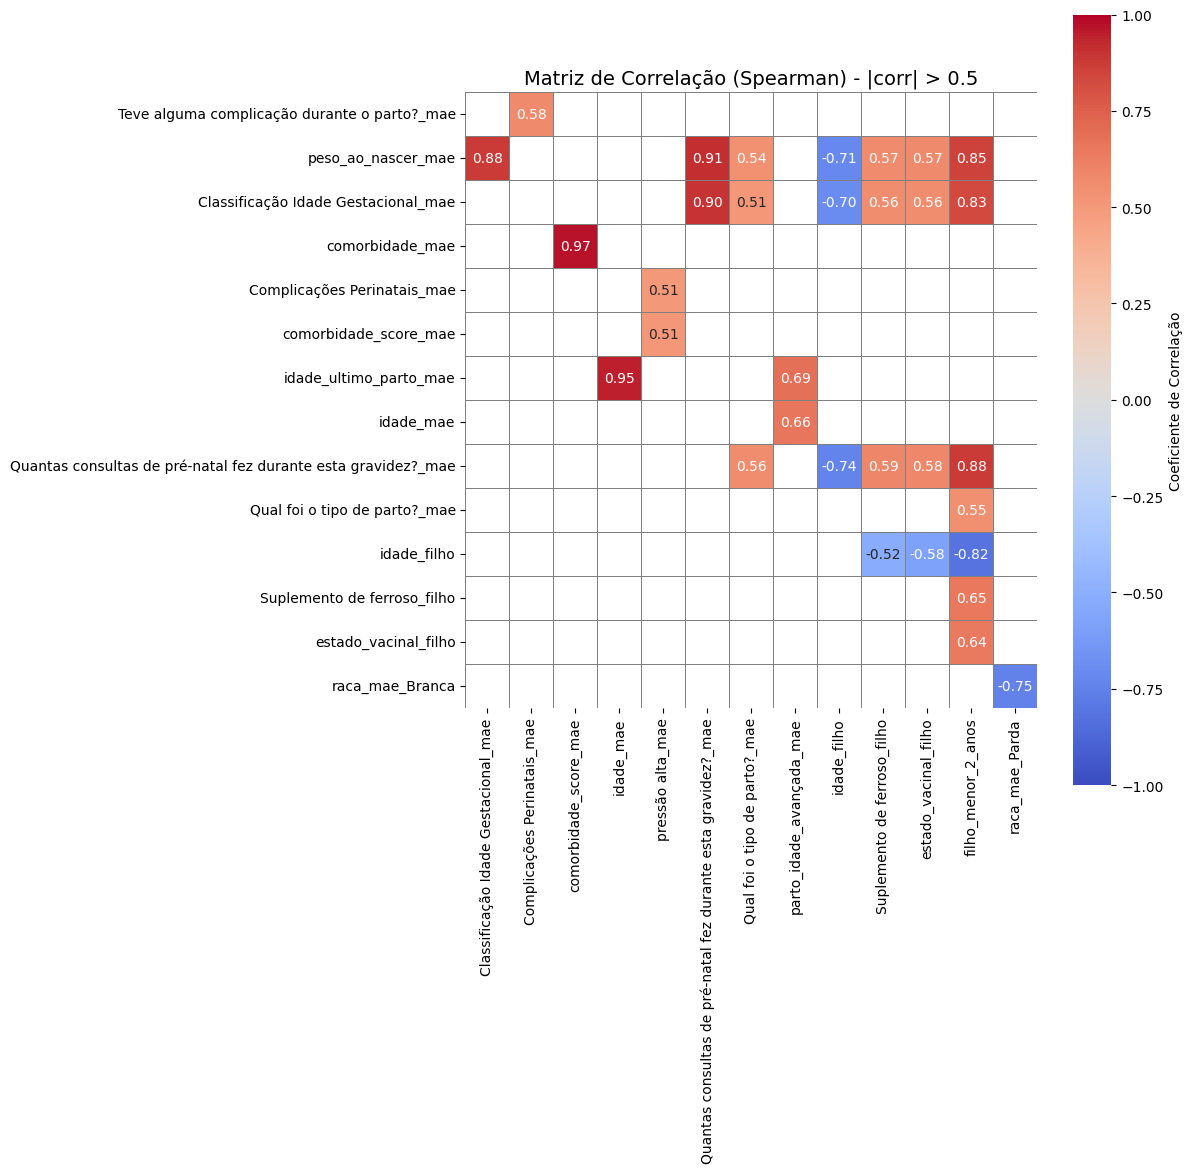

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_filtered_correlation(df, method='pearson', threshold=0.1, title='Correlação'):
    df = df.copy()
    # Seleciona apenas colunas numéricas
    df_numeric = df.select_dtypes(include=[np.number])

    # Calcula a matriz de correlação
    corr = df_numeric.corr(method=method)

    # Remove a diagonal (autocorrelação)
    np.fill_diagonal(corr.values, np.nan)

    # Cria máscara para valores abaixo do threshold e parte inferior da matriz
    mask = (corr.abs() <= threshold) | np.tril(np.ones(corr.shape), k=-1).astype(bool)

    # Aplica a máscara para remover valores irrelevantes
    filtered_corr = corr.mask(mask)

    # Remove linhas e colunas totalmente nulas
    filtered_corr = filtered_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)
    mask = filtered_corr.isna()  # atualiza máscara com base no que sobrou

    # Plot
    plt.figure(figsize=(12, 12))
    sns.heatmap(
        filtered_corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='gray',
        square=True,
        cbar_kws={"label": "Coeficiente de Correlação"},
        mask=mask
    )
    plt.title(f"Matriz de Correlação ({method.capitalize()}) - |corr| > {threshold}", fontsize=14)
    plt.tight_layout()
    plt.show()



plot_filtered_correlation(dum_df_interesse, method='spearman', threshold=0.5)

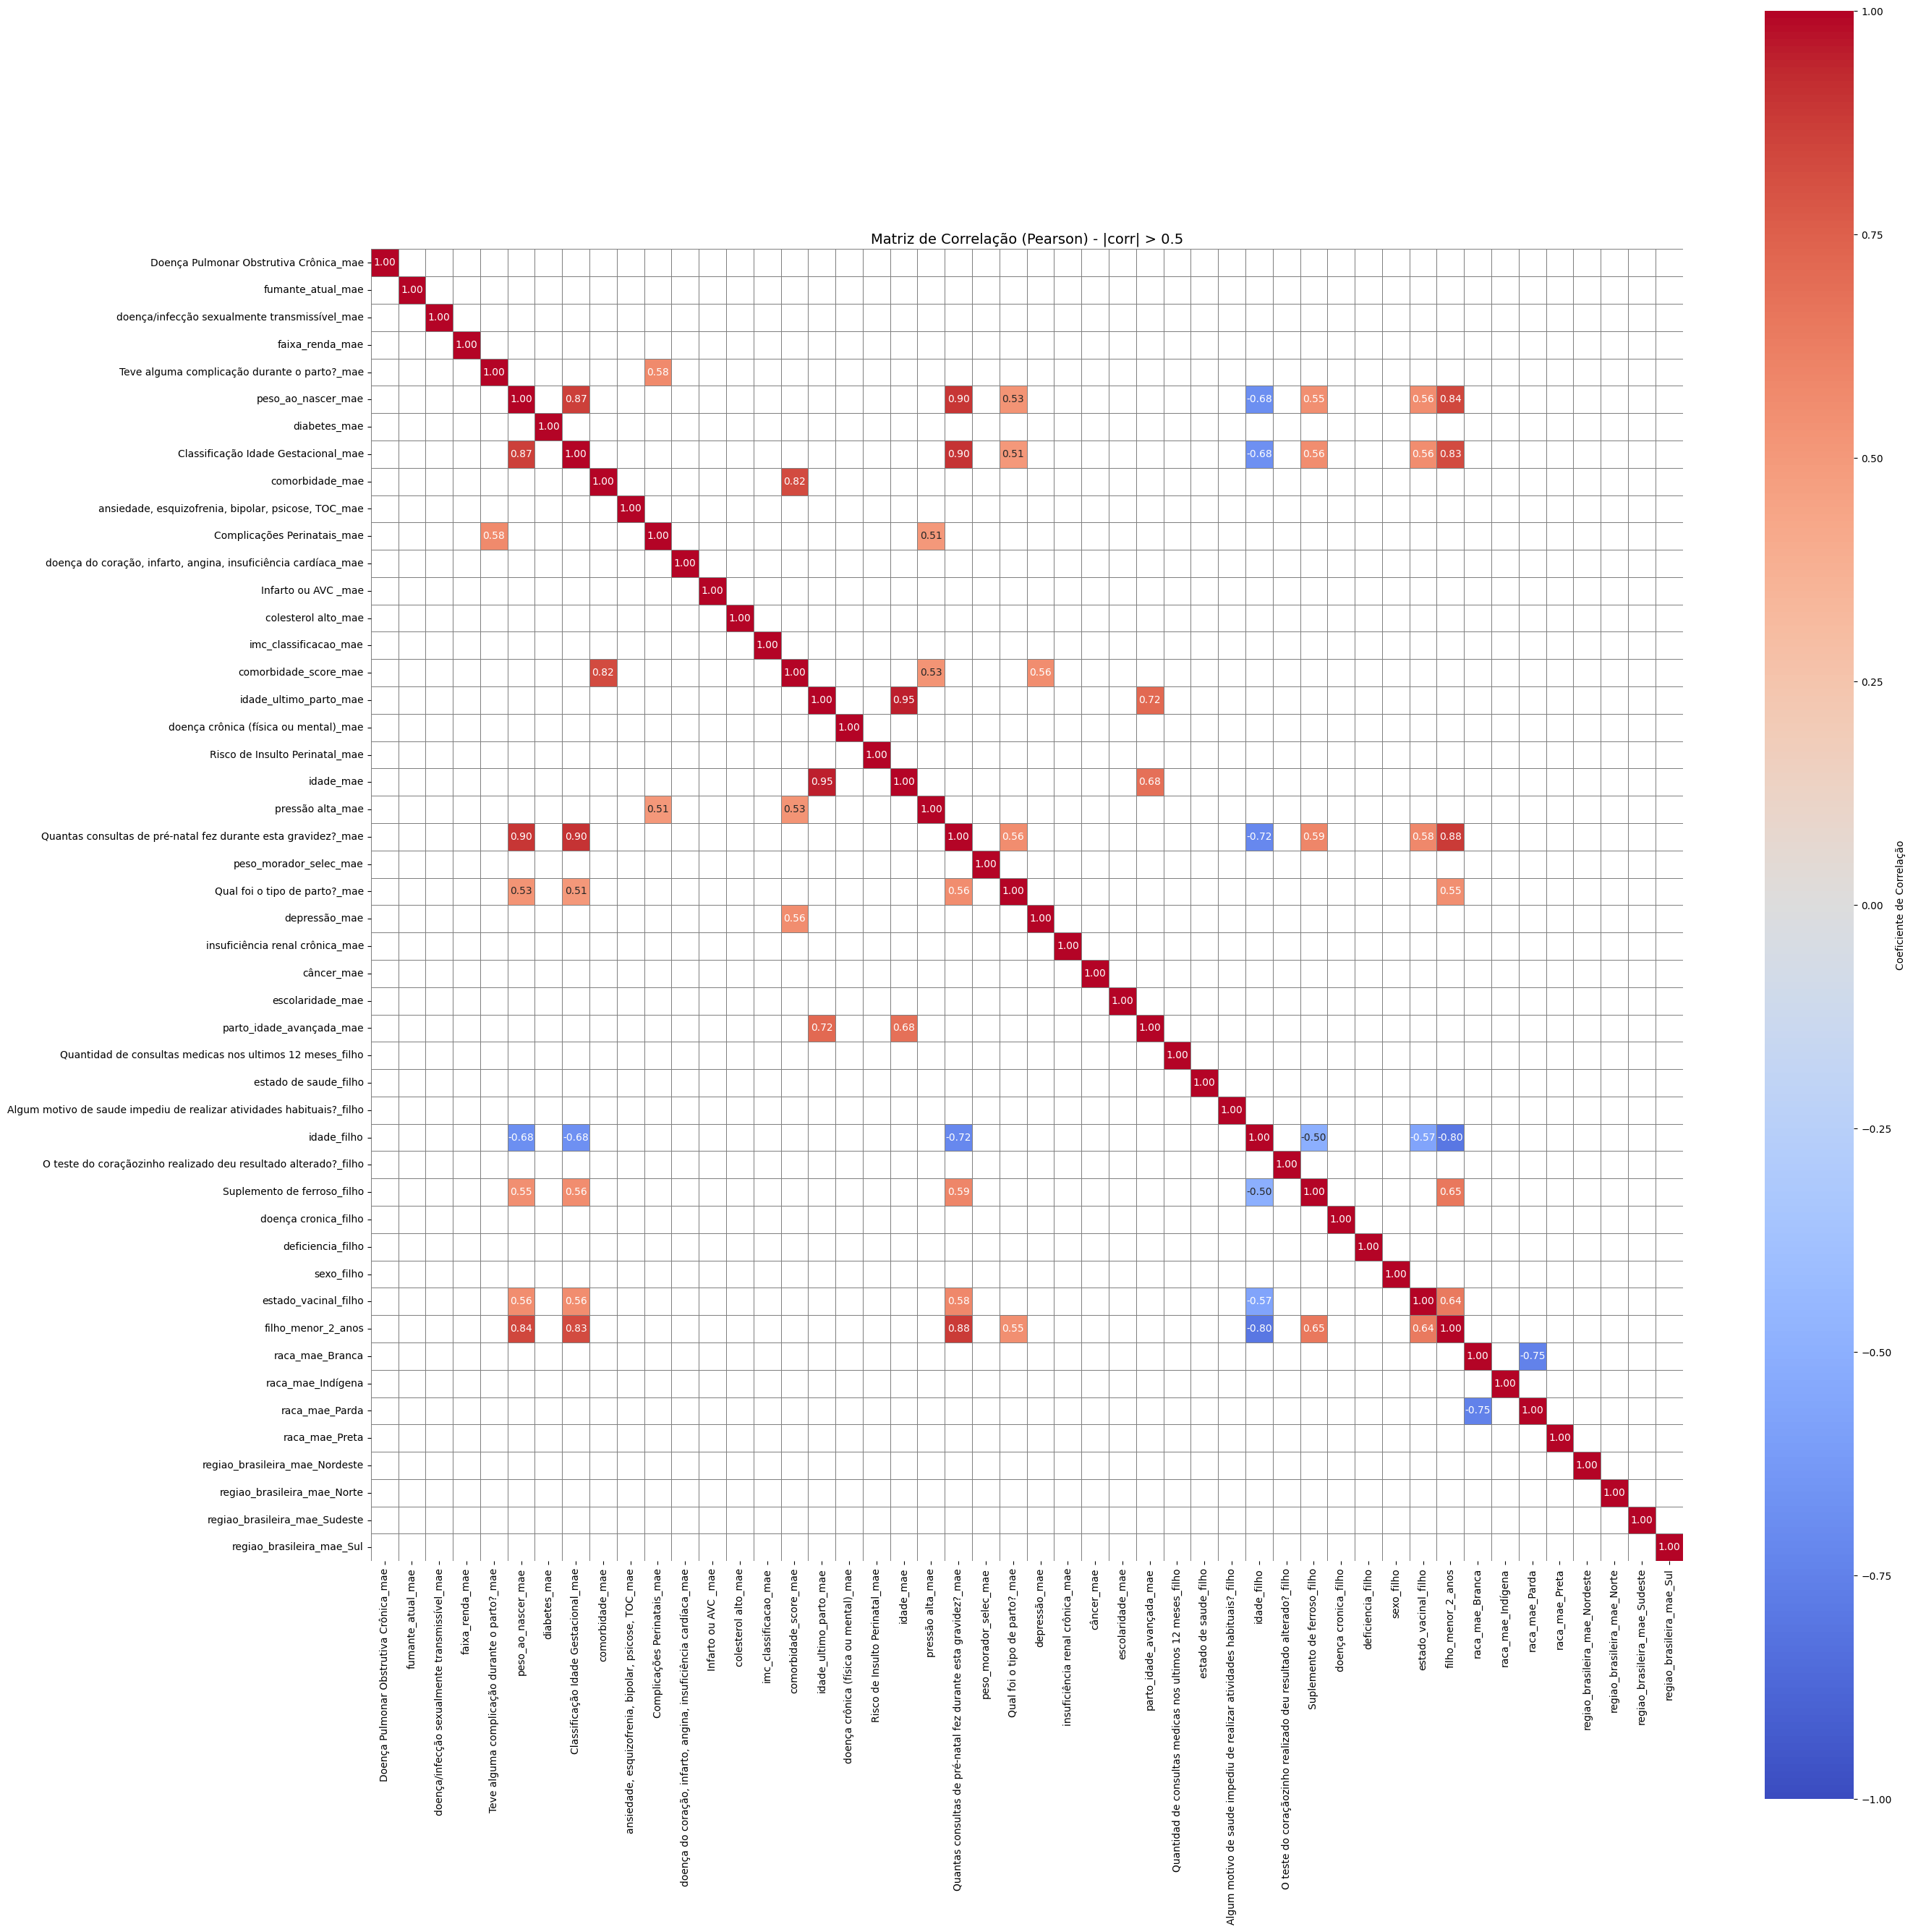

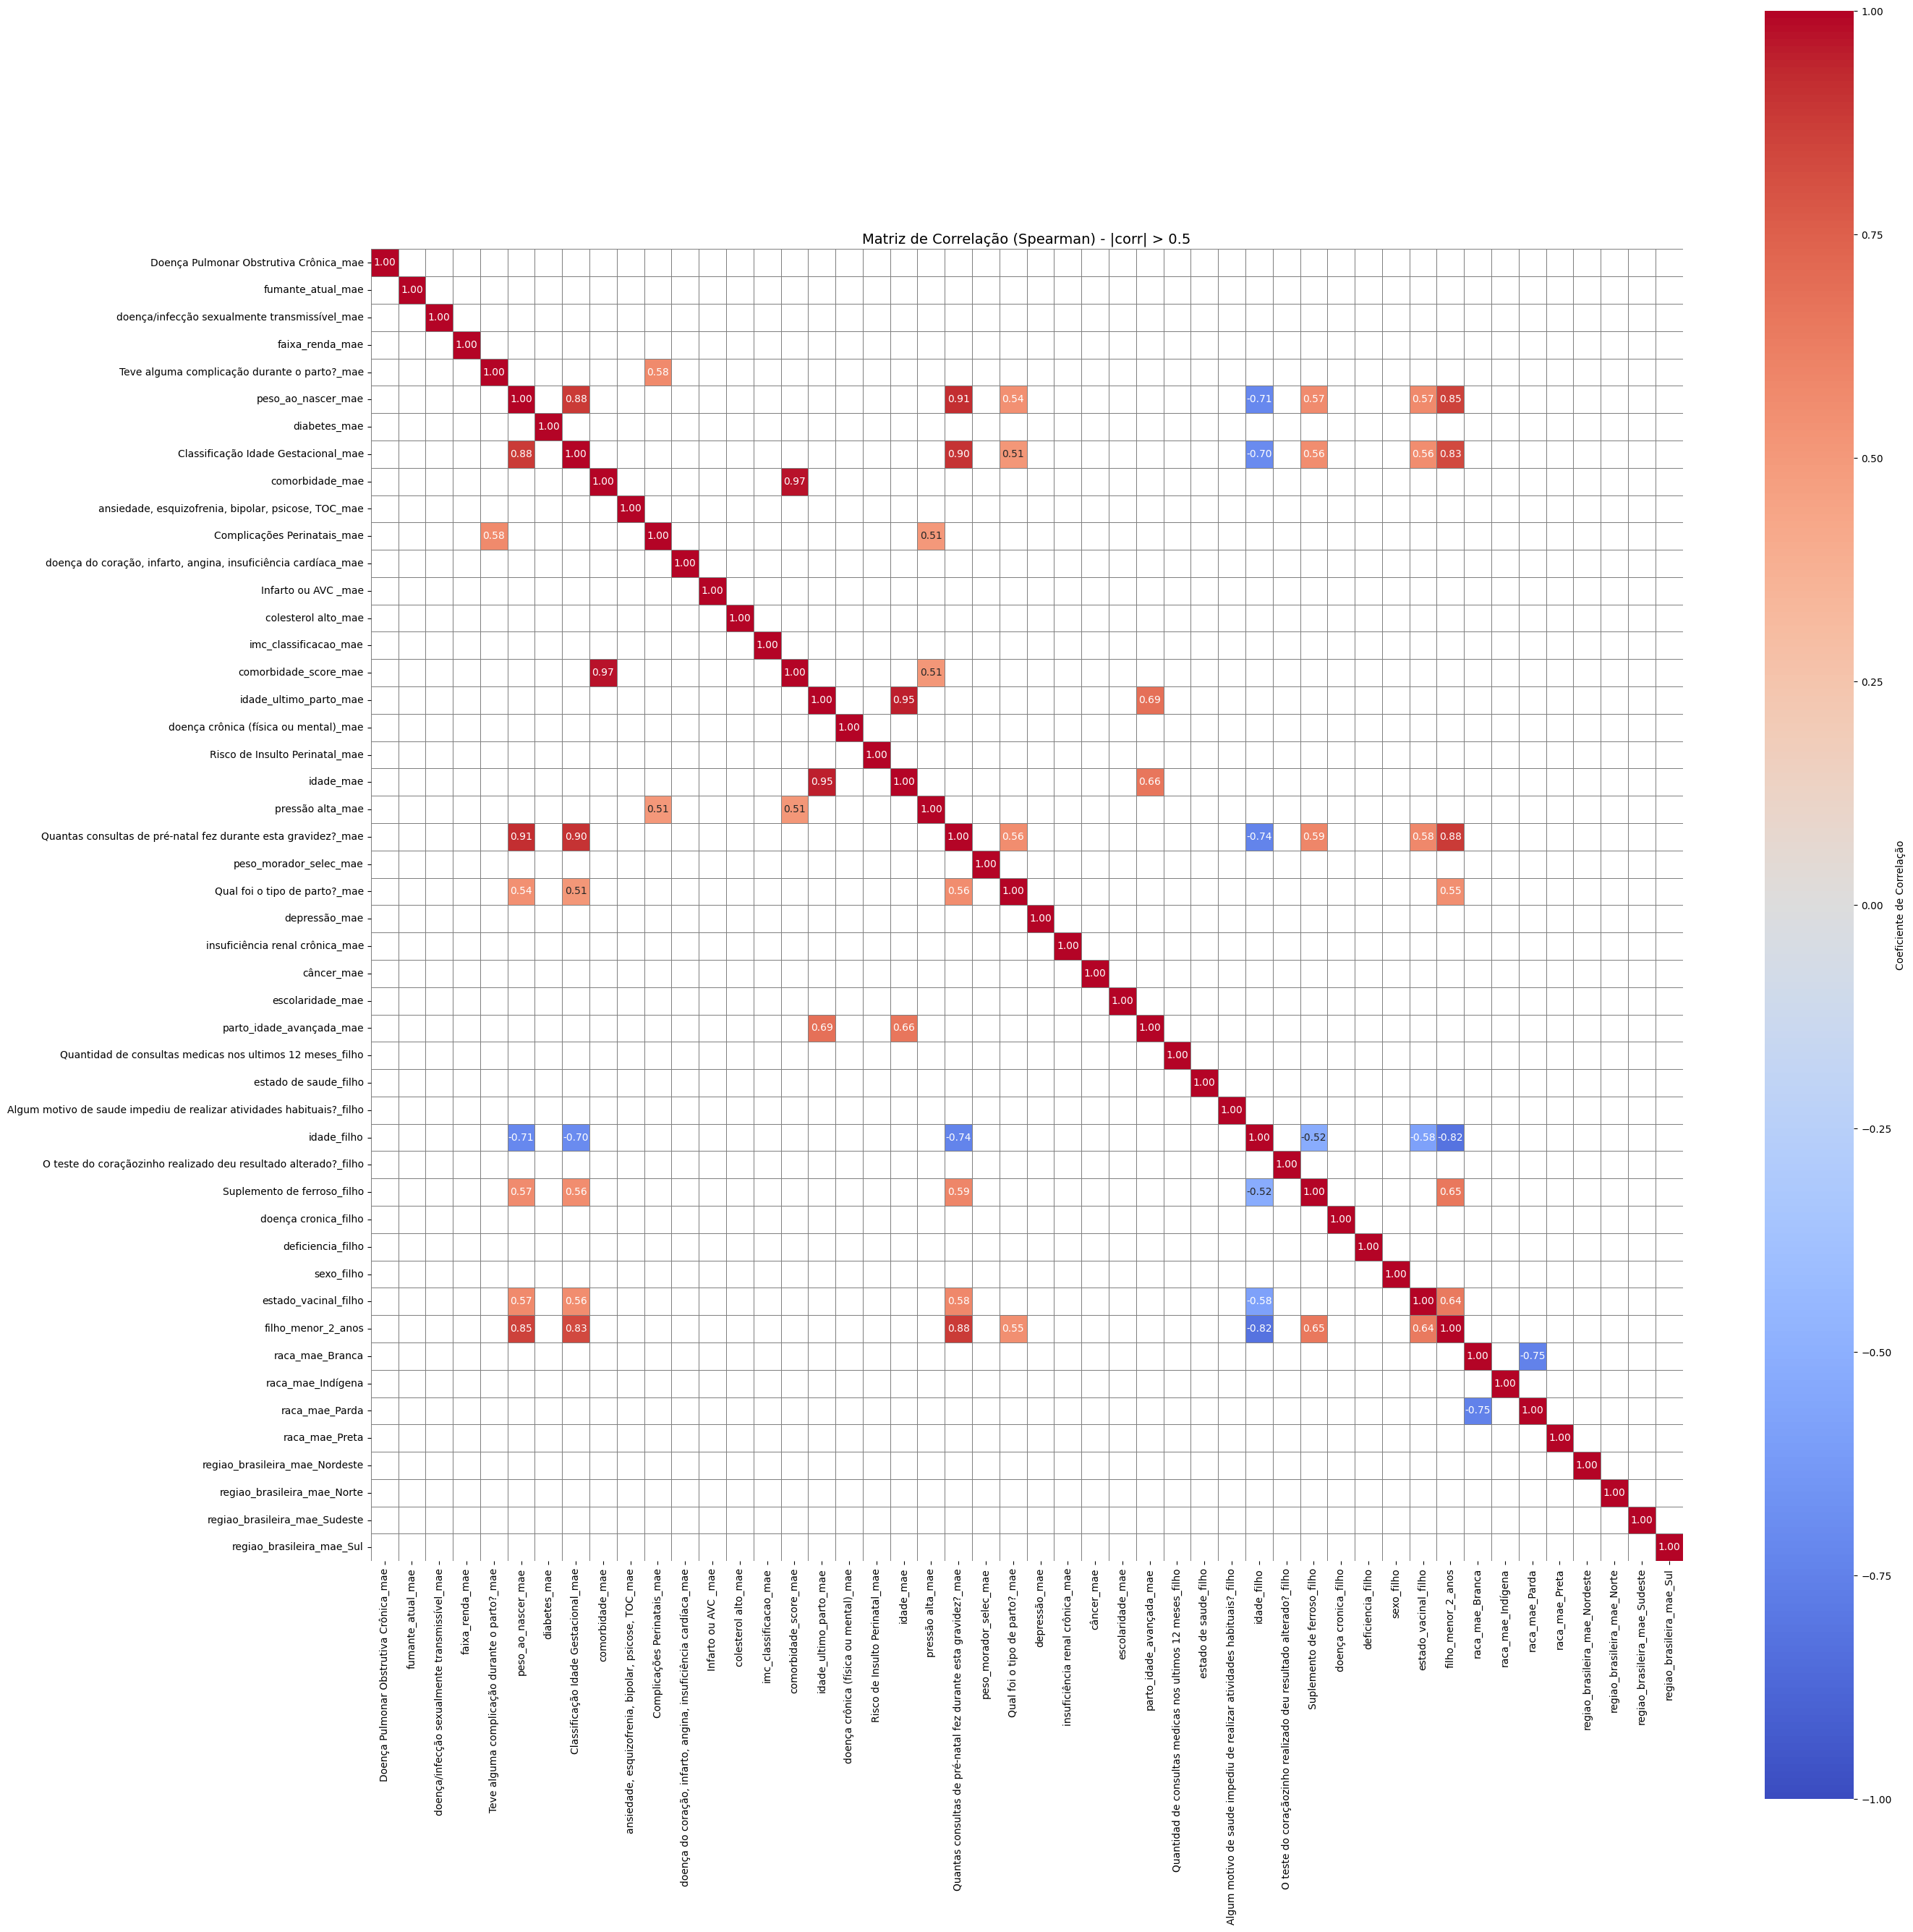

In [136]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_filtered_correlation(df, method='pearson', threshold=0.5, title='Correlação'):
    # Seleciona apenas colunas numéricas
    df_numeric = df.select_dtypes(include=[np.number])

    # Calcula a matriz de correlação
    corr = df_numeric.corr(method=method)
    
    # Aplica o filtro para manter apenas valores com |cor| > threshold
    mask = corr.abs() <= threshold
    filtered_corr = corr.mask(mask)
    
    # Plot
    plt.figure(figsize=(28, 28))
    sns.heatmap(
        filtered_corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        center=0,
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        linecolor='gray',
        square=True,
        cbar_kws={"label": "Coeficiente de Correlação"}
    )
    plt.title(f"Matriz de Correlação ({method.capitalize()}) - |corr| > {threshold}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Exemplo de uso com Pearson
plot_filtered_correlation(dum_df_interesse, method='pearson', title='Correlação de Pearson')

# Exemplo de uso com Spearman
plot_filtered_correlation(dum_df_interesse, method='spearman', title='Correlação de Spearman')


# Variaveis Dependentes x Variaveis Independentes

In [137]:
df_full = dum_df_interesse.copy()

In [138]:
# J001 - Estado de Saúde
# J00402 - Algum motivo de saúde impediu de realizar atividades habituais? motivo
# J012 - quantidade de consultas 12 meses

In [190]:
var_dependentes = [  
'Quantidad de consultas medicas nos ultimos 12 meses_filho',
'estado de saude_filho',
'Algum motivo de saude impediu de realizar atividades habituais?_filho',
'O teste do coraçãozinho realizado deu resultado alterado?_filho',
'Suplemento de ferroso_filho',
'doença cronica_filho',
'deficiencia_filho',

'sexo_filho',
'estado_vacinal_filho',
'filho_menor_2_anos',
'raca_filho',
'idade_filho',
]

id = ['peso_morador_selec_mae', 'chave_domicio', 'chave_pessoa_mae', 'chave_pessoa_filho']

var_independentes = [
'Doença Pulmonar Obstrutiva Crônica_mae',
'fumante_atual_mae',
'doença/infecção sexualmente transmissível_mae',
'faixa_renda_mae',
'Teve alguma complicação durante o parto?_mae',
'peso_ao_nascer_mae',
'diabetes_mae',
'Classificação Idade Gestacional_mae',
'comorbidade_mae',
'ansiedade, esquizofrenia, bipolar, psicose, TOC_mae',
'Complicações Perinatais_mae',
'doença do coração, infarto, angina, insuficiência cardíaca_mae',
'Infarto ou AVC _mae',
'colesterol alto_mae',
'imc_classificacao_mae',
'comorbidade_score_mae',
'idade_ultimo_parto_mae',
'doença crônica (física ou mental)_mae',
'idade_mae',
'pressão alta_mae',
'Quantas consultas de pré-natal fez durante esta gravidez?_mae', 
'Qual foi o tipo de parto?_mae',
'depressão_mae',
'insuficiência renal crônica_mae',
'câncer_mae',
'escolaridade_mae',
'parto_idade_avançada_mae',
'raca_mae_Branca',
'raca_mae_Indígena',
'raca_mae_Parda',
'raca_mae_Preta',
'regiao_brasileira_mae_Nordeste',
'regiao_brasileira_mae_Norte',
'regiao_brasileira_mae_Sudeste',
'regiao_brasileira_mae_Sul',
'Risco de Insulto Perinatal_mae',]

In [191]:
for col in var_dependentes:
    display(df_full[col].value_counts(dropna=False))
    print('\n\n')

Quantidad de consultas medicas nos ultimos 12 meses_filho
1.0     1490
2.0     1312
3.0     1083
0.0      904
4.0      743
5.0      632
6.0      459
10.0     429
12.0     271
8.0      209
7.0      118
9.0       53
15.0      39
20.0      33
11.0      22
24.0      11
14.0       8
30.0       5
16.0       4
40.0       3
25.0       3
13.0       3
36.0       3
18.0       2
96.0       2
48.0       1
60.0       1
Name: count, dtype: int64

estado de saude_filho
2.0    4958
1.0    2017
3.0     792
4.0      68
5.0       8
Name: count, dtype: int64

Algum motivo de saude impediu de realizar atividades habituais?_filho
0    7141
1     702
Name: count, dtype: int64

O teste do coraçãozinho realizado deu resultado alterado?_filho
0    7718
1     125
Name: count, dtype: int64

Suplemento de ferroso_filho
0    6513
1    1330
Name: count, dtype: int64

doença cronica_filho
0    7446
1     397
Name: count, dtype: int64

deficiencia_filho
0    7521
1     322
Name: count, dtype: int64

sexo_filho
1    3961
0    3882
Name: count, dtype: int64

estado_vacinal_filho
0    6548
1    1295
Name: count, dtype: int64

filho_menor_2_anos
0    5305
1    2538
Name: count, dtype: int64

raca_filho
Parda       4279
Branca      2948
Preta        525
Indígena      56
Amarela       35
Name: count, dtype: int64

idade_filho
1    1283
0    1255
2    1207
4    1116
3    1110
5    1013
6     859
Name: count, dtype: int64

# Modelos

In [200]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import LeaveOneOut
import time


In [194]:
df_full['estado de saude bin_filho'] = np.where(df_full['estado de saude_filho']>3, 1, 0)
df_full['Quantidad de consultas medicas nos ultimos 12 meses bin_filho'] = np.where(df_full['Quantidad de consultas medicas nos ultimos 12 meses_filho']>10, 1, 0)

df_full['deficiencia + doença'] = df_full['deficiencia_filho'] + df_full['doença cronica_filho']
df_full['deficiencia + doença'] = np.where(df_full['deficiencia + doença']>0, 1, 0)

df_full['deficiencia + doença + atividades habituais impedidas'] = df_full['deficiencia_filho'] + df_full['doença cronica_filho'] + df_full['Algum motivo de saude impediu de realizar atividades habituais?_filho']
df_full['deficiencia + doença + atividades habituais impedidas'] = np.where(df_full['deficiencia + doença + atividades habituais impedidas']>0, 1, 0)

df_full['tudo'] = df_full['deficiencia_filho'] + df_full['doença cronica_filho'] + df_full['Algum motivo de saude impediu de realizar atividades habituais?_filho'] + df_full['estado de saude bin_filho'] + df_full['Quantidad de consultas medicas nos ultimos 12 meses bin_filho']
df_full['tudo'] = np.where(df_full['tudo']>0, 1, 0)
df_full['tudo'].value_counts()

tudo
0    6306
1    1537
Name: count, dtype: int64

In [195]:
df_full['tudo + sulfato ferroso'] = df_full['tudo'] + df_full['Suplemento de ferroso_filho']
df_full['tudo + sulfato ferroso'] = np.where(df_full['tudo + sulfato ferroso']>0, 1, 0)
df_full['tudo + sulfato ferroso'].value_counts()

tudo + sulfato ferroso
0    5253
1    2590
Name: count, dtype: int64

In [202]:
def teste_variaveis_resposta(df_full, target="deficiencia_filho"):
    df_full = df_full.copy()
    # Dividir os dados
    X = df_full[var_independentes]  # Variáveis independentes
    y = df_full[target]    # Variável de desfecho
    sample_weights = df_full['peso_morador_selec_mae']  # Pesos das amostras

    # Configurar o modelo
    clf = RandomForestClassifier(random_state=42)

    # Configurar validação cruzada estratificada e repetida
    # cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
    cv = LeaveOneOut()


    # Métricas personalizadas para validação cruzada
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary'),
        'f1': make_scorer(f1_score, average='binary')
    }

    # Executar validação cruzada para cada métrica
    results = {}
    for metric_name, scorer in scoring.items():
        scores = cross_val_score(clf, X, y, scoring=scorer, cv=cv, n_jobs=11, params={'sample_weight': sample_weights})
        results[metric_name] = scores

    # Calcular e exibir as médias de cada métrica
    print("Média das métricas com validação cruzada (RepeatedStratifiedKFold):")
    for metric, scores in results.items():
        print(f"{metric.capitalize()}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

In [203]:
targets = ['Quantidad de consultas medicas nos ultimos 12 meses_filho',
'estado de saude_filho',
'Algum motivo de saude impediu de realizar atividades habituais?_filho',
'O teste do coraçãozinho realizado deu resultado alterado?_filho',
'Suplemento de ferroso_filho',
'doença cronica_filho',
'deficiencia_filho',
'estado de saude bin_filho',
'Quantidad de consultas medicas nos ultimos 12 meses bin_filho',
'deficiencia + doença',
'deficiencia + doença + atividades habituais impedidas',
'tudo',
'tudo + sulfato ferroso'
]


# Medir o tempo de execução de cada chamada
for target in targets:
    print(f"Executando para o target: {target}")
    start_time = time.time()  # Início da medição
    teste_variaveis_resposta(df_full, target=target)
    end_time = time.time()  # Fim da medição
    elapsed_time = end_time - start_time
    print(f"Tempo de execução para {target}: {elapsed_time:.2f} segundos\n\n")


Executando para o target: Quantidad de consultas medicas nos ultimos 12 meses_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.1576 ± 0.3644
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para Quantidad de consultas medicas nos ultimos 12 meses_filho: 5010.81 segundos


Executando para o target: estado de saude_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.6128 ± 0.4871
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para estado de saude_filho: 3251.74 segundos


Executando para o target: Algum motivo de saude impediu de realizar atividades habituais?_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.9045 ± 0.2939
Precision: 0.0001 ± 0.0113
Recall: 0.0001 ± 0.0113
F1: 0.0001 ± 0.0113
Tempo de execução para Algum motivo de saude impediu de realizar atividades habituais?_filho: 2312.45 segundos


Executando para o target: O teste 

# Repetir o experimento dividindo o dataset em Menores e maiores de 2 anos

### Menores

In [204]:
fil = df_full['filho_menor_2_anos'] == 1
# Medir o tempo de execução de cada chamada
for target in targets:
    print(f"Executando para o target: {target}")
    start_time = time.time()  # Início da medição
    teste_variaveis_resposta(df_full[fil].reset_index(drop=True), target=target)
    end_time = time.time()  # Fim da medição
    elapsed_time = end_time - start_time
    print(f"Tempo de execução para {target}: {elapsed_time:.2f} segundos\n\n")

Executando para o target: Quantidad de consultas medicas nos ultimos 12 meses_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.1336 ± 0.3402
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para Quantidad de consultas medicas nos ultimos 12 meses_filho: 529.48 segundos


Executando para o target: estado de saude_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.6194 ± 0.4855
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para estado de saude_filho: 399.12 segundos


Executando para o target: Algum motivo de saude impediu de realizar atividades habituais?_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.9299 ± 0.2554
Precision: 0.0000 ± 0.0000
Recall: 0.0000 ± 0.0000
F1: 0.0000 ± 0.0000
Tempo de execução para Algum motivo de saude impediu de realizar atividades habituais?_filho: 284.61 segundos


Executando para o target: O teste do 

### Maiores

In [205]:
fil = df_full['filho_menor_2_anos'] == 0
# Medir o tempo de execução de cada chamada
for target in targets:
    print(f"Executando para o target: {target}")
    start_time = time.time()  # Início da medição
    teste_variaveis_resposta(df_full[fil].reset_index(drop=True), target=target)
    end_time = time.time()  # Fim da medição
    elapsed_time = end_time - start_time
    print(f"Tempo de execução para {target}: {elapsed_time:.2f} segundos\n\n")

Executando para o target: Quantidad de consultas medicas nos ultimos 12 meses_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.1646 ± 0.3708
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para Quantidad de consultas medicas nos ultimos 12 meses_filho: 2021.57 segundos


Executando para o target: estado de saude_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.6089 ± 0.4880
Precision: nan ± nan
Recall: nan ± nan
F1: nan ± nan
Tempo de execução para estado de saude_filho: 1522.69 segundos


Executando para o target: Algum motivo de saude impediu de realizar atividades habituais?_filho
Média das métricas com validação cruzada (RepeatedStratifiedKFold):
Accuracy: 0.8933 ± 0.3087
Precision: 0.0002 ± 0.0137
Recall: 0.0002 ± 0.0137
F1: 0.0002 ± 0.0137
Tempo de execução para Algum motivo de saude impediu de realizar atividades habituais?_filho: 1133.00 segundos


Executando para o target: O teste 